Training Data Sample:
    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N 

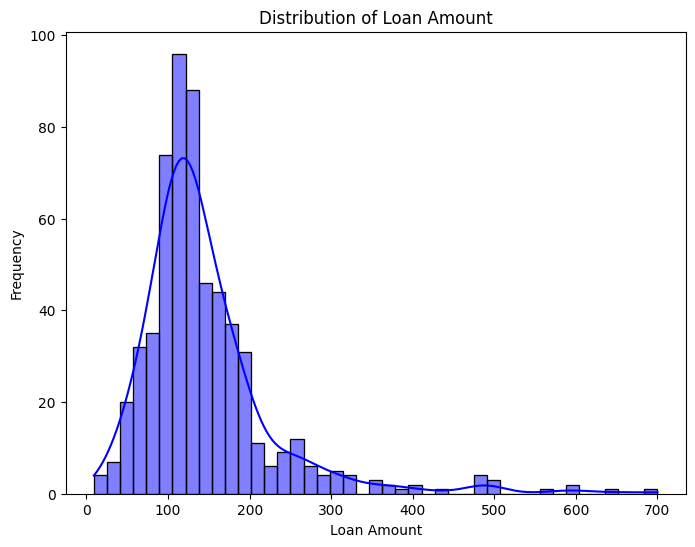

Distribution of Loan Amount


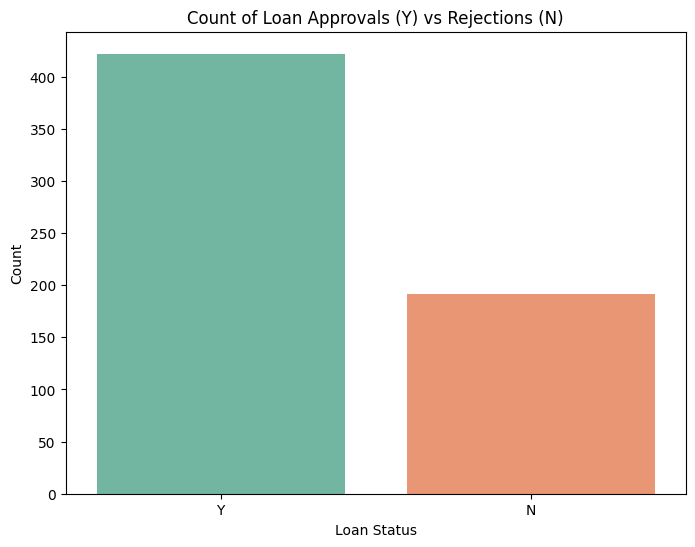

Loan Status Count Plot


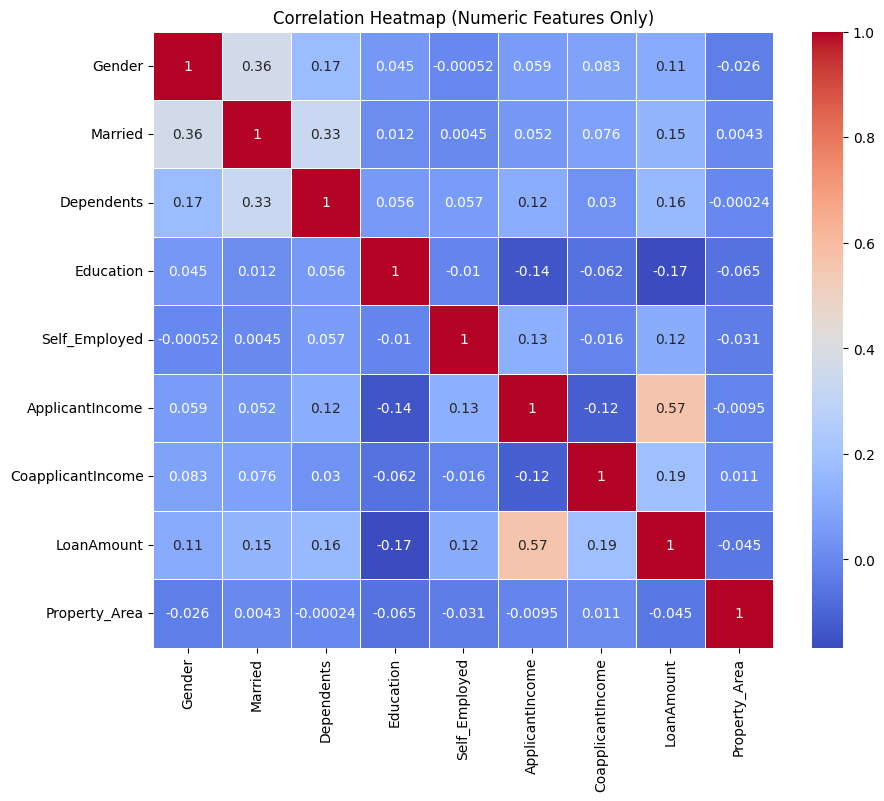


Validation Accuracy: 76.42%


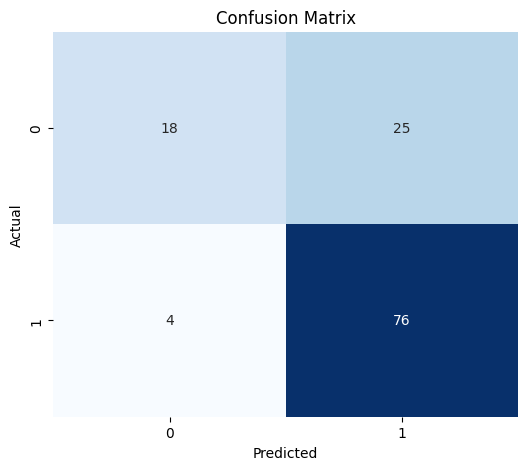

C:\Users\HP\AppData\Local\Temp\ipykernel_4344\3920786824.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=feature_names[indices], palette='viridis')


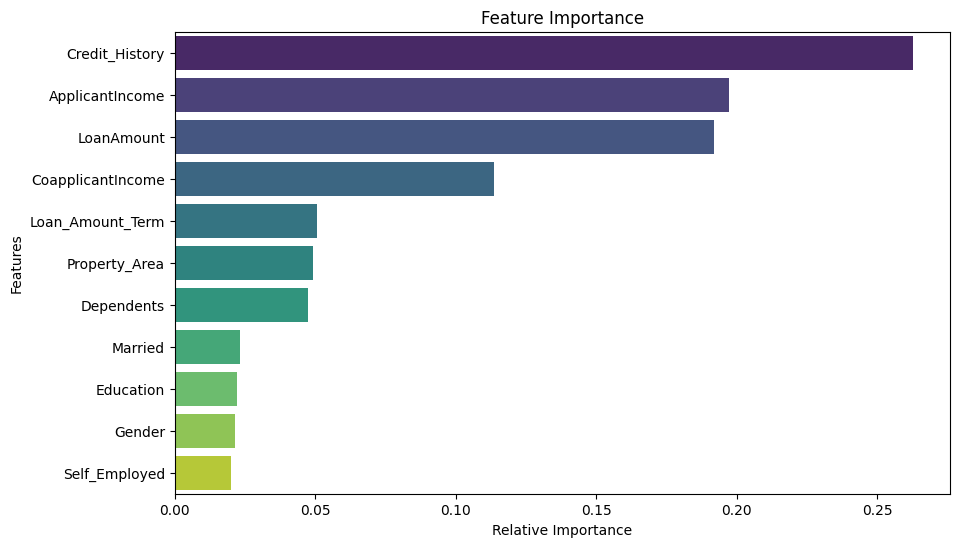


Predictions saved to 'loan_predictions.csv'.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Load training and testing data
train_data = pd.read_csv('./dataset/train.csv')
test_data = pd.read_csv('./dataset/test.csv')

# Display the first few rows of the training data
print("Training Data Sample:")
print(train_data.head())

# Display missing values in the training data
print("\nMissing values in training data:")
print(train_data.isnull().sum())

print("\nMissing values in test data:")
print(test_data.isnull().sum())

# --- Graph 1: Distribution of Loan Amount ---
plt.figure(figsize=(8,6))
sns.histplot(train_data['LoanAmount'], kde=True, color='blue')
plt.title('Distribution of Loan Amount')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.show()
print("Distribution of Loan Amount")

# --- Graph 2: Loan Status Count Plot ---
plt.figure(figsize=(8,6))
sns.countplot(x='Loan_Status', data=train_data, palette='Set2', hue='Loan_Status', dodge=False)
plt.title('Count of Loan Approvals (Y) vs Rejections (N)')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.legend([],[], frameon=False)  # remove redundant legend
plt.show()
print("Loan Status Count Plot")

# Fill missing values in numeric columns with the mean
imputer = SimpleImputer(strategy='mean')
train_data['LoanAmount'] = imputer.fit_transform(train_data[['LoanAmount']])
test_data['LoanAmount'] = imputer.transform(test_data[['LoanAmount']])

# Fill missing values in categorical columns with the most frequent value
cat_imputer = SimpleImputer(strategy='most_frequent')
categorical_cols = ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History']

train_data[categorical_cols] = cat_imputer.fit_transform(train_data[categorical_cols])
test_data[categorical_cols] = cat_imputer.transform(test_data[categorical_cols])

# Convert categorical variables into numeric using LabelEncoder
encoder = LabelEncoder()
cat_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']

for col in cat_columns:
    train_data[col] = encoder.fit_transform(train_data[col])
    test_data[col] = encoder.transform(test_data[col])

# --- Fix: Drop non-numeric columns (like Loan_ID) before computing the correlation ---
# Select only numeric columns for the correlation matrix
numeric_columns = train_data.select_dtypes(include=[np.number])

# --- Graph 3: Correlation Heatmap ---
plt.figure(figsize=(10,8))
sns.heatmap(numeric_columns.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap (Numeric Features Only)')
plt.show()

# Select the features and target variable from training data
X = train_data.drop(columns=['Loan_ID', 'Loan_Status'])
y = train_data['Loan_Status'].map({'Y': 1, 'N': 0})

# Prepare the test data (drop Loan_ID column)
X_test = test_data.drop(columns=['Loan_ID'])

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

# Predict on the validation set
y_pred_val = model.predict(X_val)

# Check accuracy on the validation set
accuracy = accuracy_score(y_val, y_pred_val)
print(f"\nValidation Accuracy: {accuracy * 100:.2f}%")

# --- Graph 4: Confusion Matrix ---
conf_matrix = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- Graph 5: Feature Importance Plot ---
importances = model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=feature_names[indices], palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.show()

# Predict loan eligibility on the test data
test_predictions = model.predict(X_test)

# Add predictions to the test dataset
test_data['Loan_Status_Predictions'] = test_predictions
test_data['Loan_Status_Predictions'] = test_data['Loan_Status_Predictions'].map({1: 'Y', 0: 'N'})

# Save the predictions to a CSV file
test_data[['Loan_ID', 'Loan_Status_Predictions']].to_csv('loan_predictions.csv', index=False)

print("\nPredictions saved to 'loan_predictions.csv'.")
